# Amini Cocoa Contamination Challenge

* We trained yolo11s models, which are fast to train (approx. 2h 30min per fold).
* Based on the resource restrictions of this challenge, quoted below:

  > "Your solutions for this challenge must be able to function in a resource-limited setting, i.e., it should run on a low-resource smartphone. As such, we are imposing the following restrictions on resources: T4 GPU, maximum 9h training, maximum 3h inference. Model frameworks must be appropriate for use on edge devices (e.g., ONNX, TensorFlow Lite)."

* Since there were no restrictions placed on ensembling, and the yolo11s models are lightweight and fast to train, we trained an ensemble of three models on folds 6, 7, and 8.
* The total inference time for the ensemble remained well under 1 hour — comfortably within the 3-hour inference budget. Specifically 40 minutes
* All models can be exported to ONNX or TensorFlow Lite and are suitable for deployment on low-resource smartphones.
* Based on the above, our solution adheres fully to the challenge rules.
* That said, even the individual (single-fold) models perform strongly and are fast enough for edge deployment on their own.


#### Environment to reproduce our experiments: Kaggle
#### Total runtime for the whole training process: 8hr 33 min

## **SETUP**

In [1]:
#!pip install ultralytics==8.3.116
#!pip install albumentations==2.0.5
!pip install ensemble-boxes

  Using cached llvmlite-0.44.0-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -------------------------

In [1]:
import ultralytics
print(ultralytics.__version__)

8.3.75


## **Libraries**

In [2]:
from collections import defaultdict
from datetime import datetime

In [4]:
import shutil
import numpy as np
import pandas as pd
import sys, os, shutil, gc, re, json, glob, math, time, random, warnings
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold
import sklearn.metrics as skm
import torch
import cv2
import yaml
import albumentations as A

from ultralytics.data.build import YOLODataset
import ultralytics.data.build as build
from ultralytics import YOLO
from ensemble_boxes import *

In [5]:
import warnings
warnings.filterwarnings("ignore")

## **Config**

In [6]:
os.listdir("C:/Users/Reinhard/Documents/computer_vision_projects/amini_cocoa_contamination_challenge")

['cocoa_dataset.yaml',
 'Cocoa_Disease_Starter_Notebook.ipynb',
 'dataset',
 'dataset.zip',
 'dataset_6',
 'Interpretability_Report.ipynb',
 'notebook_one.ipynb',
 'SampleSubmission.csv',
 'Test.csv',
 'Train.csv',
 'Training_Notebook.ipynb',
 'yolov8m.pt',
 'yolov8n.pt',
 'yolov8s.pt']

In [7]:
class CFG:

    train_csv_path = "Train.csv"
    test_csv_path = "Test.csv"

    image_path = "C:/Users/Reinhard/Documents/computer_vision_projects/amini_cocoa_contamination_challenge/"

    N_SPLITS = 10
    RANDOM_STATE = 41
    FOLDS= [0]
    YOLO_SEED = 127


In [8]:
def fix_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False

In [22]:
fix_seed(CFG.RANDOM_STATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **UTILS**

In [14]:
def split_data(df):

    gkf  = StratifiedGroupKFold(n_splits=CFG.N_SPLITS,
                                shuffle=True, random_state=CFG.RANDOM_STATE)

    df['fold'] = -1

    for fold_id, (train_index, test_index) in enumerate(gkf.split(df, y=df['class'], groups=df.Image_ID)):

        df.loc[test_index,'fold'] = fold_id

    return df

In [15]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_bboxes(image_id, df, label_map=None):
    """
    Displays the image with its bounding boxes.

    Parameters:
    - image_id (str): The filename of the image (e.g., 'ID_nBgcAR.jpg')
    - df (pd.DataFrame): DataFrame with bbox info, must include:
        ['Image_ID', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id', 'ImagePath']
    - label_map (dict, optional): Maps class_id to class name (e.g., {0: 'Blight', 1: 'Healthy'})
    """
    # Filter DataFrame
    image_data = df[df['Image_ID'] == image_id]

    if image_data.empty:
        print(f"No annotations found for image: {image_id}")
        return

    # Load the image
    image_path = CFG.image_path + image_data['ImagePath'].values[0]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.imshow(image)
    ax.set_title(image_id)

    # Draw bounding boxes
    for _, row in image_data.iterrows():
        xmin, ymin, xmax, ymax = row[['xmin', 'ymin', 'xmax', 'ymax']]
        class_id = int(row['class_id'])
        class_name = label_map[class_id] if label_map else str(class_id)

        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, class_name, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

In [16]:
def normalize_bounding_box(bbox, image_width = None, image_height = None):
    """
    Normalize bounding box coordinates for YOLO format.
    bbox: [xmin, ymin, xmax, ymax]
    Returns: [x_center, y_center, width, height] all normalized between 0 and 1
    """
    xmin, ymin, xmax, ymax = bbox
    box_width = xmax - xmin
    box_height = ymax - ymin
    x_center = xmin + box_width / 2
    y_center = ymin + box_height / 2

    return np.array([
        x_center / image_width,
        y_center / image_height,
        box_width / image_width,
        box_height / image_height
    ])

In [17]:
def prepare_yolo_dataset(metadata, split_name, dataset_root):
    output_dir = os.path.join(dataset_root, split_name)
    image_dir = os.path.join(output_dir, 'images')
    label_dir = os.path.join(output_dir, 'labels')

    shutil.rmtree(output_dir, ignore_errors=True)
    os.makedirs(image_dir)
    os.makedirs(label_dir)

    split_df = metadata[metadata['split'] == split_name].copy()
    split_df.to_csv(os.path.join(output_dir, 'submission_format.csv'), index=False)

    print(f"Preparing '{split_name}' split → Images: {split_df.Image_ID.nunique()} | Annotations: {len(split_df)}")

    # Preprocess: group annotations and paths
    grouped = split_df.dropna(subset=['xmin', 'ymin', 'xmax', 'ymax', 'class_id']) \
                      .groupby('Image_ID')

    image_paths = split_df.groupby('Image_ID')['path'].first().to_dict()

    for image_id, annotations in tqdm(grouped, total=len(grouped)):
        image_path = image_paths[image_id]
        image_filename = os.path.basename(image_path)
        dest_image_path = os.path.join(image_dir, image_filename)

        shutil.copy2(image_path, dest_image_path)

        # Read image once
        image = cv2.imread(dest_image_path)
        if image is None:
            print(f"⚠️ Failed to load image: {image_path}")
            continue
        height, width = image.shape[:2]

        label_lines = []
        for row in annotations.itertuples():
            if row.class_id == -1:
                continue

            xmin, ymin, xmax, ymax = row.xmin, row.ymin, row.xmax, row.ymax
            if xmax - xmin < 1 or ymax - ymin < 1:
                print(f"Invalid bbox skipped in image: {image_id}")
                continue

            yolo_bbox = normalize_bounding_box([xmin, ymin, xmax, ymax], width, height)
            label_lines.append(f"{int(row.class_id)}\t" + '\t'.join(map(str, yolo_bbox)))

        if label_lines:
            label_filename = os.path.splitext(image_filename)[0] + '.txt'
            with open(os.path.join(label_dir, label_filename), 'w') as f:
                f.write('\n'.join(label_lines))


In [18]:
from sklearn.model_selection import train_test_split

def generate_split_and_prepare_yolo_format(fold_index, metadata_df, dataset_root):
    """
    Generate split and prepare YOLO dataset folders.

    Parameters:
    - fold_index (int): Fold number to use for validation split
    - metadata_df (DataFrame): Data containing fold info and annotations
    - dataset_root (str): Directory where YOLO folders will be created
    """

    # Start with everything as train
    metadata_df['split'] = 'train'

    # Extract the fold to be used for validation
    valid_df = metadata_df[metadata_df['fold'] == fold_index]

    # Group by Image_ID for stratified splitting
    image_level = (
        valid_df.groupby('Image_ID')
        .agg({'class': lambda x: x.mode()[0]})  # Representative class
        .reset_index()
    )

    # Stratified split of validation fold
    img_valid1, img_valid2 = train_test_split(
        image_level,
        test_size=0.5,
        stratify=image_level['class'],
        random_state=CFG.RANDOM_STATE
    )

    # IDs for new splits
    valid1_ids = set(img_valid1['Image_ID'])
    valid2_ids = set(img_valid2['Image_ID'])

    # Assign new validation split
    metadata_df.loc[metadata_df['Image_ID'].isin(valid2_ids), 'split'] = 'valid'

    # Verify no overlap
    train_ids = set(metadata_df[metadata_df['split'] == 'train']['Image_ID'])
    valid_ids = set(metadata_df[metadata_df['split'] == 'valid']['Image_ID'])

    intersection = train_ids.intersection(valid_ids)
    print("Intersection of Image_IDs between train and valid:", intersection)
    assert len(intersection) == 0, "Image_IDs overlap between train and valid!"

    print(metadata_df['split'].value_counts())

    # Print class distribution in the new valid set
    valid_class_dist = metadata_df[metadata_df['split'] == 'valid']['class'].value_counts()
    print("\nClass distribution in the new valid set:\n", valid_class_dist)

    # Prepare YOLO datasets
    for split in ['train', 'valid']:
        prepare_yolo_dataset(metadata_df, split, dataset_root)


In [19]:
class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts

        # Aggregation function
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()

    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
              weights.append(1)
              continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

## **Dataset**

In [23]:
train = pd.read_csv(CFG.train_csv_path)
test = pd.read_csv(CFG.test_csv_path)

train.shape, test.shape

((9792, 9), (1626, 9))

In [24]:
# strip any spacing from the class item and make sure it is a string
train['class'] = train['class'].str.strip()
class_map = {cls: i for i, cls in enumerate(sorted(train['class'].unique().tolist()))}
label_map = {v:k for k,v in class_map.items()}
cols =  ['xmin','ymin','xmax','ymax']
train[cols] = train[cols].astype(int)

train['class_id'] = train['class'].map(class_map)
train["path"] = train["ImagePath"].apply(lambda x: f"{CFG.image_path}{x}")
test["path"] = test["ImagePath"].apply(lambda x: f"{CFG.image_path}{x}")

In [25]:
train.head(3)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath,path
0,ID_nBgcAR.jpg,healthy,1.0,75,15,162,195,2,dataset/images/train/ID_nBgcAR.jpg,C:/Users/Reinhard/Documents/computer_vision_pr...
1,ID_nBgcAR.jpg,healthy,1.0,58,1,133,171,2,dataset/images/train/ID_nBgcAR.jpg,C:/Users/Reinhard/Documents/computer_vision_pr...
2,ID_nBgcAR.jpg,healthy,1.0,42,29,377,349,2,dataset/images/train/ID_nBgcAR.jpg,C:/Users/Reinhard/Documents/computer_vision_pr...


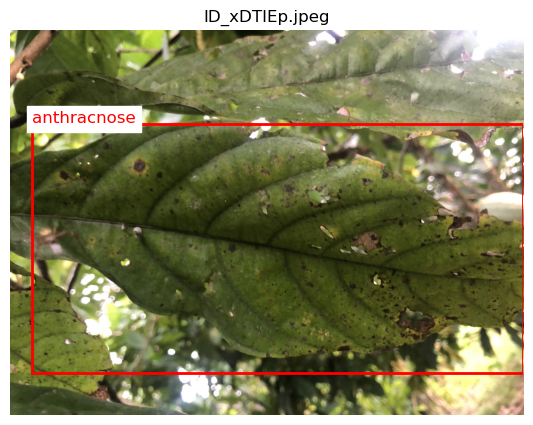

In [26]:
 plot_image_with_bboxes('ID_xDTIEp.jpeg', train, label_map)

## **Data Splitting**

In [27]:
train = split_data(train)
train.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath,path,fold
0,ID_nBgcAR.jpg,healthy,1.0,75,15,162,195,2,dataset/images/train/ID_nBgcAR.jpg,C:/Users/Reinhard/Documents/computer_vision_pr...,8
1,ID_nBgcAR.jpg,healthy,1.0,58,1,133,171,2,dataset/images/train/ID_nBgcAR.jpg,C:/Users/Reinhard/Documents/computer_vision_pr...,8
2,ID_nBgcAR.jpg,healthy,1.0,42,29,377,349,2,dataset/images/train/ID_nBgcAR.jpg,C:/Users/Reinhard/Documents/computer_vision_pr...,8
3,ID_Kw2v8A.jpg,healthy,1.0,112,124,404,341,2,dataset/images/train/ID_Kw2v8A.jpg,C:/Users/Reinhard/Documents/computer_vision_pr...,7
4,ID_Kw2v8A.jpg,healthy,1.0,148,259,413,412,2,dataset/images/train/ID_Kw2v8A.jpg,C:/Users/Reinhard/Documents/computer_vision_pr...,7


In [28]:
for fold in range(CFG.N_SPLITS):
  d = train[train.fold==fold]['class'].value_counts().to_dict()
  print(fold, d)

0 {'healthy': 429, 'cssvd': 318, 'anthracnose': 224}
1 {'healthy': 405, 'cssvd': 343, 'anthracnose': 230}
2 {'healthy': 483, 'cssvd': 321, 'anthracnose': 204}
3 {'healthy': 433, 'cssvd': 295, 'anthracnose': 225}
4 {'healthy': 450, 'cssvd': 334, 'anthracnose': 234}
5 {'healthy': 411, 'cssvd': 303, 'anthracnose': 260}
6 {'healthy': 428, 'cssvd': 332, 'anthracnose': 226}
7 {'healthy': 423, 'cssvd': 330, 'anthracnose': 218}
8 {'healthy': 397, 'cssvd': 327, 'anthracnose': 232}
9 {'healthy': 421, 'cssvd': 338, 'anthracnose': 218}


## **Create YOLO format dataset**

## **Train Model**

In [30]:
%%time

for FOLD in [6,7,8]:
    IMGSZ = 800
    MODEL_NAME = 'yolo8s'

    # build.YOLODataset = YOLOWeightedDataset
    run_dir = f'train_fold_{FOLD}_model_{MODEL_NAME}_imgs_{IMGSZ}'
    DATASET_DIRECTORY = f'C:/Users/Reinhard/Documents/computer_vision_projects/amini_cocoa_contamination_challenge/dataset_{FOLD}'

    os.makedirs(DATASET_DIRECTORY,exist_ok=True)

    conf = {
            'path': DATASET_DIRECTORY,
            'train': 'train/images',
            'val': 'valid/images',
            'nc': len(label_map),
            'names': label_map
        }

    with open(f'{DATASET_DIRECTORY}/config.yaml','w') as f:
        yaml.dump(conf,f,default_flow_style=False)


    print(f"========================= Running fold {FOLD} =======================================")
    generate_split_and_prepare_yolo_format(FOLD,
                                           train, DATASET_DIRECTORY)


    model = YOLO(f'{MODEL_NAME}.pt')

    results = model.train(data=f'{DATASET_DIRECTORY}/config.yaml',
                          epochs=50,
                          imgsz=IMGSZ,
                          # project = project,  # 👈 where 'runs' will be saved
                          name=run_dir,
                          device=0,
                          batch=10,
                          optimizer='AdamW',
                          lr0=3e-4,
                          momentum=0.9,
                          weight_decay=1e-2,
                          close_mosaic=20,
                          seed=CFG.YOLO_SEED,
                          # patience=10  # 👈 Add this for early stopping after 10 epochs without improvement
    )

    shutil.rmtree(DATASET_DIRECTORY)


========================= Running fold 6 =======================================
Intersection of Image_IDs between train and valid: set()
split
train    9294
valid     498
Name: count, dtype: int64

Class distribution in the new valid set:
 class
healthy        227
cssvd          152
anthracnose    119
Name: count, dtype: int64
Preparing 'train' split → Images: 5253 | Annotations: 9294


100%|██████████| 5253/5253 [13:41<00:00,  6.39it/s]


Preparing 'valid' split → Images: 276 | Annotations: 498


100%|██████████| 276/276 [00:43<00:00,  6.33it/s]


ConnectionError: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/ultralytics/assets/releases/tags/v8.3.0 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001FABF6674A0>: Failed to resolve 'api.github.com' ([Errno 11001] getaddrinfo failed)"))